In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, OrderedDict
import itertools
from os import path
import ipywidgets as widgets
import seaborn as sns
import warnings
import random
import json

warnings.filterwarnings('ignore')

In [2]:
## Setting up working directory
data_dir = r"C:/Users/Saurabh/OneDrive/Documents/Kaggle Projects/jigsaw-toxic-comment-classification-challenge/Data/"
train_path = path.join(data_dir, r"train/")
print(train_path)

C:/Users/Saurabh/OneDrive/Documents/Kaggle Projects/jigsaw-toxic-comment-classification-challenge/Data/train/


In [3]:
data = pd.read_csv(train_path + "train.csv")

In [4]:
def describe_data(df):
    df['multilabel_count'] = df.sum(axis = 1)
    dd = {}
    dd['Data Length'] = len(df)
    dd['multilabel_count'] = df[df['multilabel_count'] >= 2].sum()
    for i in df.columns:
        dd[i] = df.loc[:,i].sum()
        dd[i+'_ratio'] = round(df.loc[:,i].sum()/len(df),2)*100
    return dd


In [5]:
dd = describe_data(data.iloc[:,2:])

In [6]:
dd

{'Data Length': 159571,
 'multilabel_count': 35098,
 'toxic': 15294,
 'toxic_ratio': 10.0,
 'severe_toxic': 1595,
 'severe_toxic_ratio': 1.0,
 'obscene': 8449,
 'obscene_ratio': 5.0,
 'threat': 478,
 'threat_ratio': 0.0,
 'insult': 7877,
 'insult_ratio': 5.0,
 'identity_hate': 1405,
 'identity_hate_ratio': 1.0,
 'multilabel_count_ratio': 22.0}

In [7]:
data_sub = data.iloc[:1000,]

In [8]:
@widgets.interact(text = list(data_sub['comment_text']))
def toxicity_class(text = data_sub['comment_text'][0]):
    print(text,"\n", data_sub.loc[data_sub['comment_text'] == text, ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']])

interactive(children=(Dropdown(description='text', options=("Explanation\nWhy the edits made under my username…

Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27 
    toxic  severe_toxic  obscene  threat  insult  identity_hate
0      0             0        0       0       0              0


In [9]:
for i in data.columns[2:]:
    print(data.loc[:, i].value_counts())

0    144277
1     15294
Name: toxic, dtype: int64
0    157976
1      1595
Name: severe_toxic, dtype: int64
0    151122
1      8449
Name: obscene, dtype: int64
0    159093
1       478
Name: threat, dtype: int64
0    151694
1      7877
Name: insult, dtype: int64
0    158166
1      1405
Name: identity_hate, dtype: int64


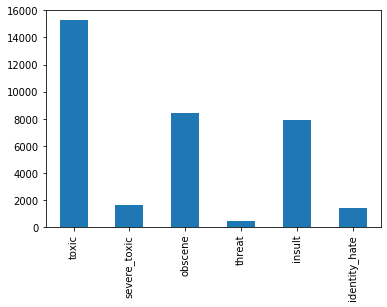

In [10]:
## Plotting the distribution of toxicity classes
data.iloc[:, 2:].sum().plot(kind = 'bar')

0    143346
1      6360
3      4209
2      3480
4      1760
5       385
6        31
Name: Multilabel, dtype: int64


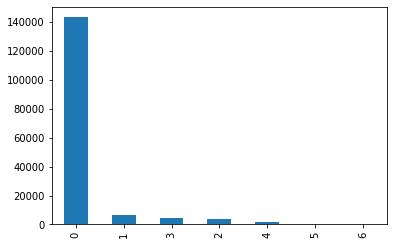

In [11]:
#Plotting frequency of single or multiple categories for each text
data['Multilabel'] = data.iloc[:, 2:].sum(axis = 1)
data['Multilabel'].value_counts().plot(kind = 'bar')
print(data['Multilabel'].value_counts())

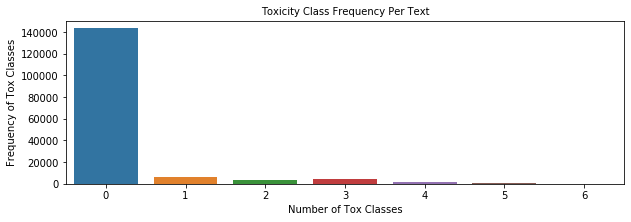

In [12]:
count, freq = zip(*Counter(data['Multilabel']).items())
plt.figure(figsize = (10,3))
ax = sns.barplot(list(count), list(freq))
plt.title('Toxicity Class Frequency Per Text', fontsize = 10)
plt.xlabel('Number of Tox Classes', fontsize = 10)
plt.ylabel('Frequency of Tox Classes', fontsize = 10)
plt.show()

In [13]:
## Setting the seeds for reproducibility
seeds = 7
np.random.seed(seeds)
random.seed(seeds)


In [14]:
## Shuffling the data
data = data.sample(frac=1).reset_index(drop = True)

In [15]:
## Separating dependent and independent variables
X = data['comment_text'].to_numpy()
y = data.iloc[:, 2:-1].to_numpy()

# Splitting

In [16]:
from sklearn.model_selection import train_test_split
from skmultilearn.model_selection.measures import get_combination_wise_output_matrix

In [17]:
## Split sizes
train_size = 0.7
val_size = 0.15
test_size = 0.15

In [18]:
X_train, X_, y_train, y_ = train_test_split(X, y, train_size = train_size)
X_val, X_test, y_val, y_test = train_test_split(X_, y_, train_size = 0.5)

In [19]:
print(f"Train Size : {len(X_train)} ({len(X_train)/len(X):.2f})\n"
        f"Remaining : {len(X_)} ({len(X_)/len(X):.2f})")

Train Size : 111699 (0.70)
Remaining : 47872 (0.30)


In [20]:
## Get counts for each class
counts = {}
counts['train'] = Counter(str(combination) for row in get_combination_wise_output_matrix(y_train, order=1) for combination in row)
counts['val'] = Counter(str(combination) for row in get_combination_wise_output_matrix(y_val, order=1) for combination in row)
counts['test'] = Counter(str(combination) for row in get_combination_wise_output_matrix(y_test, order=1) for combination in row)

# Adjust counts across splits
for k in counts['val'].keys():
    counts['val'][k] = int(counts['val'][k] * \
        (train_size/val_size))
for k in counts['test'].keys():
    counts['test'][k] = int(counts['test'][k] * \
        (train_size/test_size))

## Creating counts dataframe
counts_df = pd.DataFrame({
    'train' : counts['train'],
    'val' : counts['val'],
    'test' : counts['test'],
}).T
counts_df

(2,)   (0,)  (1,)  (4,)  (5,)  (3,)
train  5958  10731  1130  5575   991   339
val    5833  10649  1022  5334   942   322
test   5791  10644  1148  5408   989   326

In [21]:
## Calculating Standard Deviation to check how scattered are the distributions
np.mean(np.std(counts_df.to_numpy(), axis = 0))

49.525979160454945

In [22]:
from skmultilearn.model_selection import IterativeStratification

In [23]:
def iterative_train_test_split(X, y, train_size):

    stratifier = IterativeStratification(n_splits=2, order = 1, sample_distribution_per_fold = [1-train_size, train_size, ])
    train_indices, test_indices = next(stratifier.split(X, y))

    X_train, y_train = X[train_indices], y[train_indices]
    X_test, y_test = X[test_indices], y[test_indices]

    return X_train, X_test, y_train, y_test

In [24]:
## Separating dependent and independent variables
X = data['comment_text'].to_numpy()
y = data.iloc[:, 2:-1].to_numpy()

In [25]:
# Split
X_train, X_, y_train, y_ = iterative_train_test_split(
    X, y, train_size=train_size)
X_val, X_test, y_val, y_test = iterative_train_test_split(
    X_, y_, train_size=0.5)

In [26]:
## Get counts for each class
counts = {}
counts['train'] = Counter(str(combination) for row in get_combination_wise_output_matrix(y_train, order=1) for combination in row)
counts['val'] = Counter(str(combination) for row in get_combination_wise_output_matrix(y_val, order=1) for combination in row)
counts['test'] = Counter(str(combination) for row in get_combination_wise_output_matrix(y_test, order=1) for combination in row)

# Adjust counts across splits
for k in counts['val'].keys():
    counts['val'][k] = int(counts['val'][k] * \
        (train_size/val_size))
for k in counts['test'].keys():
    counts['test'][k] = int(counts['test'][k] * \
        (train_size/test_size))

## Creating counts dataframe
counts_df = pd.DataFrame({
    'train' : counts['train'],
    'val' : counts['val'],
    'test' : counts['test'],
}).T
counts_df

(2,)   (0,)  (4,)  (5,)  (1,)  (3,)
train  5914  10706  5514   983  1105   335
val    5917  10705  5511   984  1096   308
test   5912  10705  5516   984  1190   359

In [27]:
## Calculating Standard Deviation to check how scattered are the distributions
np.mean(np.std(counts_df.to_numpy(), axis = 0))

11.37257921623259

# Preprocessing 

In [28]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

In [29]:
nltk.download('stopwords')
STOPWORDS = stopwords.words('english')
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Saurabh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
def preprocessing(text, lower = True, stem = False, filters = "[!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~]", stopwords = STOPWORDS):

    # Lower
    if lower:
        text = text.lower()
    
    # Remove stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords) + r')\b\s*')
    text = pattern.sub('', text)

    # Spacing and filters
    text = re.sub(r"([-;;.,!?<=>])", r" \1 ", text)
    text = re.sub(filters, r"", text)
    text = re.sub('[^A-Za-z0-9]+', ' ', text) # remove non alphanumeric chars
    text = re.sub(' +', ' ', text)  # remove multiple spaces
    text = text.strip()

    # Remove links
    text = re.sub(r'http\S+', '', text)

    # Stemming
    if stem:
        text = " ".join([stemmer.stem(word) for word in text.split(' ')])

    return text


In [31]:
data_sub = data.iloc[:1000,]
@widgets.interact(text = list(data_sub['comment_text']), lower = True, stem = False)
def display_process_text(lower, stem, text = data_sub['comment_text'][0]):
    processed_text = preprocessing(text, lower=lower, stem = stem)
    print(processed_text)

interactive(children=(Checkbox(value=True, description='lower'), Checkbox(value=False, description='stem'), Dr…

In [32]:
## Applying preprocessing to entire train text data
processed_data = data.copy()
processed_data.comment_text = processed_data.comment_text.apply(preprocessing, lower = True, stem = False)
processed_data.comment_text[:5]

0    nagisa oshima tv documentaries hi think nagisa...
1    notice thank creating useful bots blue formerl...
2    attack article onwards using pib report lot ed...
3    mike reiss mike reiss actually makes comment f...
4    article could tidied someone familiar english ...
Name: comment_text, dtype: object

In [33]:
## Augmenting text with NLPAug and test models on this data separately
# import nlpaug.augmenter.word as naw

In [34]:
# #Loading tokenizers and transformers
# substitution = naw.ContextualWordEmbsAug(model_path='distilbert-base-uncased', action='substitute')
# insertion = naw.ContextualWordEmbsAug(model_path='distilbert-base-uncased', action='insert')

In [35]:
# text = processed_data.comment_text[45]
# substituted_text = substitution.augment(text)
# inserted_text = insertion.augment(text)
# print(text, "\n", substituted_text, "\n", inserted_text)

# Modelling

In [36]:
from sklearn.metrics import precision_recall_fscore_support
import torch

In [37]:
#Setting seeds
def set_seed(seed = 1234):
    "Set seeds for reproducibility"
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [38]:
## Splitting data again
def get_data_splits(df):

    ## Separating dependent and independent variables
    X = df['comment_text'].to_numpy()
    y = df.iloc[:, 2:-1].to_numpy()

    # Split
    X_train, X_, y_train, y_ = iterative_train_test_split(
        X, y, train_size=train_size)
    X_val, X_test, y_val, y_test = iterative_train_test_split(
        X_, y_, train_size=0.5)

    return X_train, X_val, X_test, y_train, y_val, y_test

In [39]:
class Trainer(object):
    def __init__(self, model, device, loss_fn = None, optimizer = None, scheduler = None):

        self.model = model
        self.device = device
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler
    
    def train_step(self, dataloader):

        #Set model to train mode
        self.model.train()
        loss = 0.0

        ## Iterate over dataloader batches
        for i, batch in enumerate(dataloader):
            
            ## Step
            batch = [item.to(self.device) for item in batch] #set batch to device
            inputs, targets = batch[:-1], batch[-1]
            self.optimizer.zero_grad() #Reset gradients
            z = self.model(inputs) #Forward Pass
            J = self.loss_fn(z, targets) #Define loss
            J.backward() #Backward Pass
            self.optimizer.step() #update weights

            # Calculating cumulative loss at intermediate steps
            loss += (J.detach().item() - loss) / (i+1)

        return loss
    
    def eval_step(self, dataloader):

        #Set model to eval mode
        self.model.eval()
        loss = 0.0
        y_trues, y_probs = [], []

        ##Iterate over val batches
        with torch.no_grad():
            for i, batch in enumerate(dataloader):
                
                ## Step
                batch = [item.to(self.device) for item in batch] #set batch to device
                inputs, y_true = batch[:-1], batch[-1]
                z = self.model(inputs) #Forward Pass
                J = self.loss_fn(z, y_true).item() #Get loss
                
                # Calculating cumulative loss at intermediate steps
                loss += (J - loss) / (i+1)

                ##Store outputs
                y_prob = torch.sigmoid(z).cpu().numpy()
                y_probs.extend(y_prob)
                y_trues.extend(y_true.cpu().numpy())

        return loss, np.vstack(y_trues), np.vstack(y_probs)
    
    def predict_step(self, dataloader):

        #Set model to eval mode
        self.model.eval()
        y_probs = []

        ##Iterate over val batches
        with torch.no_grad():
            for i, batch in enumerate(dataloader):

                #Step with inputs
                inputs, targets = batch[:-1], batch[-1]
                y_prob = self.model(inputs)

                y_probs.extend(y_prob)

        return np.vstack(y_probs)
    
    def train(self, num_epochs, patience, train_dataloader, val_dataloader):
        
        best_val_loss = np.inf
        for epoch in range(num_epochs):

            # Steps
            train_loss = self.train_step(dataloader = train_dataloader)
            val_loss, _ , _ = self.eval_step(dataloader = val_dataloader)
            self.scheduler.step(val_loss)

            # Early Stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = self.model
                _patience = patience # reset patience
            
            else:
                patience -= 1
            
            if not _patience:
                print('Early Stopping')
                break
        
            # Logging
            print(
                f"Epoch : {epoch+1} |"
                f"Train Loss : {train_loss : .5f},"
                f"Val Loss : {val_loss : .5f},"
                f"lr : {self.optimizer.param_groups[0]['lr'] : .2E}"
                f"_patience : {_patience}"
            )

        return best_model


In [40]:
def get_metrics(y_true, y_pred, classes):
    "Per Class performance metrics"
    
    #Performance
    performance = {'Overall' : {}, 'Class' : {}}

    #Overall performance
    metrics = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    performance['Overall']['Precision'] = metrics[0]
    performance['Overall']['Recall'] = metrics[1]
    performance['Overall']['F-Score'] = metrics[2]
    performance['Overall']['Num_Samples'] = np.float64(len(y_true))

    #Per class performance
    metrics = precision_recall_fscore_support(y_true, y_pred, average=None)
    for i in range(len(classes)):
        performance['Class'][classes[i]] = {
            "Precision" : metrics[0][i],
            "Recall" : metrics[1][i],
            "F-Score" : metrics[2][i],
            "Num_Samples" : np.float64(metrics[3][i]),
        } 
    
    return performance

# Baseline with Simple ML

In [41]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

In [42]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import MultiLabelBinarizer

In [43]:
# Set seed
set_seed()

In [44]:
## Creating a copy of data and applying preprocessing
processed_data = data.copy()
processed_data.comment_text = processed_data.comment_text.apply(preprocessing, lower = True, stem = False)
processed_data.comment_text[:5]

0    nagisa oshima tv documentaries hi think nagisa...
1    notice thank creating useful bots blue formerl...
2    attack article onwards using pib report lot ed...
3    mike reiss mike reiss actually makes comment f...
4    article could tidied someone familiar english ...
Name: comment_text, dtype: object

In [45]:
X_train, X_val, X_test, y_train, y_val, y_test = get_data_splits(processed_data)

print(
    f"X_train : {X_train.shape}",
    f"X_val : {X_val.shape}",
    f"X_test : {X_test.shape}",
    f"y_train : {y_train.shape}",
    f"y_val : {y_val.shape}",
    f"y_test : {y_test.shape}",
    )
print(X_train[10])

X_train : (111699,) X_val : (23936,) X_test : (23936,) y_train : (111699, 6) y_val : (23936, 6) y_test : (23936, 6)
incorrectly wish state xenophobia clinical phobia say like phobias actually know phobias anyway doctorate


In [46]:
## Creating TF-IDF from processed data
vectorizer = TfidfVectorizer()
print(X_train[0])
X_train = vectorizer.fit_transform(X_train)
X_val = vectorizer.transform(X_val)
X_test = vectorizer.transform(X_test)
print(X_train.shape)
print(X_train[0])

nagisa oshima tv documentaries hi think nagisa oshima tv documentary titles english aka actually translations wikipedians go brackets like sugoi eiga great film rather using aka
(111699, 180644)
  (0, 166891)	0.09134061426957131
  (0, 128710)	0.09573121090928956
  (0, 61811)	0.12311977791624851
  (0, 69641)	0.09755847475202384
  (0, 54186)	0.24680527887050033
  (0, 149794)	0.24680527887050033
  (0, 93393)	0.062367130699754005
  (0, 26632)	0.17644454301821894
  (0, 68192)	0.08271182973782111
  (0, 173569)	0.13300048239080572
  (0, 160002)	0.16650717957365552
  (0, 9986)	0.0909775272751948
  (0, 12009)	0.30519801173514166
  (0, 55857)	0.10348441290746857
  (0, 158398)	0.1384238032894747
  (0, 50561)	0.16280669659219685
  (0, 157271)	0.06806855544589879
  (0, 74078)	0.09147630460810434
  (0, 50560)	0.19719990259905662
  (0, 161539)	0.2607728137206273
  (0, 115074)	0.49361055774100066
  (0, 106133)	0.47683480487071395


In [47]:
def fit_and_evaluate(model):
    "Fit and evaluate each simple model"
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    performance = get_metrics(y_true=y_test, y_pred=y_pred, classes = list(data.columns[2:-1]))
    return performance['Overall']

In [48]:
performance = {}

# performance['Logistic Regression'] = fit_and_evaluate(OneVsRestClassifier(LogisticRegression(), n_jobs = 1))
# performance['Random Forest'] = fit_and_evaluate(RandomForestClassifier(n_jobs = -1))
# performance['K-Neighbors Classifier'] = fit_and_evaluate(KNeighborsClassifier())
# performance['Gradient Boosting'] = fit_and_evaluate(OneVsRestClassifier(GradientBoostingClassifier()))
# performance['Linear SVC'] = fit_and_evaluate(OneVsRestClassifier(LinearSVC(), n_jobs = -1))

# print(json.dumps(performance, indent = 2))

#### For a baseline SVC seems to be giving good enough F1-score to start with and we'll now move on to increasing complexity in models along with better data representations

## CNN with Embeddings

In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

In [50]:
## Set seeds
set_seed()

In [51]:
## Get data splits
X_train, X_val, X_test, y_train, y_val, y_test = get_data_splits(processed_data)
X_test_raw = X_test

In [52]:
## Set device
cuda = True
device = torch.device('cuda' if (torch.cuda.is_available() and cuda) else 'cpu')
torch.set_default_tensor_type('torch.FloatTensor')
if device.type == 'cuda':
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
print(device)

cuda


### Lets convert our word tokens to character level tokens to capture more contextual meaning as well as making the model robust against spelling errors of toxic words
### For that let's create our own Tokenizer class to convert word tokens to character tokens and vice-versa

In [53]:
class Tokenizer(object):
    def __init__(self, char_level, num_tokens = None, pad_token = '<PAD>', oov_token = '<UNK>', token_to_index = None):

        self.char_level = char_level
        self.separator = '' if self.char_level else ' '
        if num_tokens: num_tokens -= 2 # pad+unkown tokens
        self.num_tokens = num_tokens
        self.pad_token = pad_token
        self.oov_token = oov_token
        if not token_to_index:
            token_to_index = {pad_token: 0, oov_token: 1}
        self.token_to_index = token_to_index
        self.index_to_token = {v: k for k,v in self.token_to_index.items()}
    
    def __len__(self):
        return len(self.token_to_index)
    
    def __str__(self):
        return f"<Tokenizer(num_tokens = {len(self)})>"

    def fit_on_texts(self, texts):
        if not self.char_level:
            texts = [text.split(" ") for text in texts]
        all_tokens = [token for text in texts for token in text]
        counts = Counter(all_tokens).most_common(self.num_tokens)
        self.min_token_freq = counts[-1][1]
        for token, count in counts:
            index = len(self)
            self.token_to_index[token] = index
            self.index_to_token[index] = token
        return self
    
    def texts_to_sequences(self, texts):
        sequences = []
        for text in texts:
            if not self.char_level:
                text = text.split(' ')
            sequence = []
            for token in text:
                sequence.append(self.token_to_index.get(
                    token, self.token_to_index[self.oov_token]))
            sequences.append(np.asarray(sequence))
        return sequences
    
    def sequences_to_texts(self, sequences):
        texts = []
        for sequence in sequences:
            text = []
            for index in sequences:
                text.append(self.index_to_token.get(index, self.oov_token))
            texts.append(self.separator.join([token for token in text]))
        return texts
    
    def save(self, fp):
        with open(fp, 'w') as fp:
            contents = {
                'char_level' : self.char_level,
                'oov_token' : self.oov_token,
                'token_to_index' : self.token_to_index
            }
            json.dump(contents, fp, indent=4, sort_keys=False)
    
    @classmethod
    def load(cls, fp):
        with open(fp, 'r') as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)


In [54]:
char_level = True
tokenizer = Tokenizer(char_level=char_level)
tokenizer.fit_on_texts(texts = X_train)
vocab_size = len(tokenizer)
print(tokenizer)

<Tokenizer(num_tokens = 39)>


In [55]:
tokenizer.token_to_index

{'<PAD>': 0,
 '<UNK>': 1,
 ' ': 2,
 'e': 3,
 'i': 4,
 'a': 5,
 't': 6,
 'n': 7,
 's': 8,
 'r': 9,
 'o': 10,
 'l': 11,
 'c': 12,
 'd': 13,
 'p': 14,
 'u': 15,
 'g': 16,
 'm': 17,
 'h': 18,
 'y': 19,
 'k': 20,
 'w': 21,
 'b': 22,
 'f': 23,
 'v': 24,
 '1': 25,
 '0': 26,
 'x': 27,
 '2': 28,
 'j': 29,
 'q': 30,
 'z': 31,
 '9': 32,
 '3': 33,
 '5': 34,
 '4': 35,
 '8': 36,
 '7': 37,
 '6': 38}

In [56]:
## Convert text into sequences of indices
X_train = np.array(tokenizer.texts_to_sequences(X_train))
X_val = np.array(tokenizer.texts_to_sequences(X_val))
X_test = np.array(tokenizer.texts_to_sequences(X_test))
processed_text = tokenizer.sequences_to_texts(X_train[10])[0]
print("Text to indices:\n"
    f" (Processed) -> {processed_text}\n"
    f" (Tokenized) -> {X_train[10]}"
)

Text to indices:
 (Processed) -> incorrectly wish state xenophobia clinical phobia say like phobias actually know phobias anyway doctorate
 (Tokenized) -> [ 4  7 12 10  9  9  3 12  6 11 19  2 21  4  8 18  2  8  6  5  6  3  2 27
  3  7 10 14 18 10 22  4  5  2 12 11  4  7  4 12  5 11  2 14 18 10 22  4
  5  2  8  5 19  2 11  4 20  3  2 14 18 10 22  4  5  8  2  5 12  6 15  5
 11 11 19  2 20  7 10 21  2 14 18 10 22  4  5  8  2  5  7 19 21  5 19  2
 13 10 12  6 10  9  5  6  3]


#### Converting our data into torch's Dataset and use a Dataloader to efficiently create batches for training and evaluation

In [57]:
def pad_sequences(sequences, max_seq_len=0):
    max_seq_len = max(max_seq_len, max(len(sequence) for sequence in sequences))
    padded_sequences = np.zeros((len(sequences), max_seq_len))
    for i, sequence in enumerate(sequences):
        padded_sequences[i][:len(sequence)] = sequence
    return padded_sequences

In [58]:
class CNNTextDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, max_filter_size):
        self.X = X
        self.y = y
        self.max_filter_size = max_filter_size

    def __len__(self):
        return len(self.y)

    def __str__(self):
        return f"<Dataset(N={len(self)})>"
    
    def __getitem__(self, index):
        X = self.X[index]
        y = self.y[index]
        return [X, y]
    
    def collate_fn(self, batch):
        """Processing on a batch"""
        # Get inputs
        batch = np.array(batch, dtype = object)
        X = batch[:, 0]
        y = np.stack(batch[:, 1], axis=0)

        # Pad inputs
        X = pad_sequences(sequences = X, max_seq_len = self.max_filter_size)

        # Cast
        X = torch.LongTensor(X.astype(np.int32))
        y = torch.FloatTensor(y.astype(np.int32))

        return X, y
    
    def create_dataloader(self, batch_size, shuffle = False, drop_last = False):
        return torch.utils.data.DataLoader(
            dataset = self,
            batch_size = batch_size,
            collate_fn = self.collate_fn,
            shuffle = shuffle,
            drop_last = drop_last,
            pin_memory = True
        )
    

In [59]:
filter_sizes = list(range(1,3))
train_dataset = CNNTextDataset(X = X_train, y = y_train, max_filter_size = max(filter_sizes))
val_dataset = CNNTextDataset(X = X_val, y = y_val, max_filter_size = max(filter_sizes))
test_dataset = CNNTextDataset(X = X_test, y = y_test, max_filter_size = max(filter_sizes))

print("Data Splits:\n"
    f" Train Dataset: {train_dataset.__str__()}\n"
    f" Val Dataset: {val_dataset.__str__()}\n"
    f" Test Dataset: {test_dataset.__str__()}\n"
    "Sample point:\n"
    f" X: {train_dataset[0][0]}\n"
    f" y: {train_dataset[0][1]}")

Data Splits:
 Train Dataset: <Dataset(N=111699)>
 Val Dataset: <Dataset(N=23936)>
 Test Dataset: <Dataset(N=23936)>
Sample point:
 X: [ 7  5 16  4  8  5  2 10  8 18  4 17  5  2  6 24  2 13 10 12 15 17  3  7
  6  5  9  4  3  8  2 18  4  2  6 18  4  7 20  2  7  5 16  4  8  5  2 10
  8 18  4 17  5  2  6 24  2 13 10 12 15 17  3  7  6  5  9 19  2  6  4  6
 11  3  8  2  3  7 16 11  4  8 18  2  5 20  5  2  5 12  6 15  5 11 11 19
  2  6  9  5  7  8 11  5  6  4 10  7  8  2 21  4 20  4 14  3 13  4  5  7
  8  2 16 10  2 22  9  5 12 20  3  6  8  2 11  4 20  3  2  8 15 16 10  4
  2  3  4 16  5  2 16  9  3  5  6  2 23  4 11 17  2  9  5  6 18  3  9  2
 15  8  4  7 16  2  5 20  5]
 y: [0 0 0 0 0 0]


In [60]:
## Create DataLoaders
batch_size = 128
train_dataloader = train_dataset.create_dataloader(batch_size = batch_size)
val_dataloader = val_dataset.create_dataloader(batch_size = batch_size)
test_dataloader = test_dataset.create_dataloader(batch_size = batch_size)

batch_X, batch_y = next(iter(train_dataloader))
print("Sample Batch:\n"
    f" X: {list(batch_X.size())}\n"
    f" y: {list(batch_y.size())}")

Sample Batch:
 X: [128, 1730]
 y: [128, 6]


### Model

In [61]:
## Arguments
embedding_dim = 128
num_filters = 128
hidden_dim = 128
dropout_p = 0.5
num_classes = 6

In [62]:
class CNN(nn.Module):
    def __init__(self, embedding_dim, vocab_size, num_filters, filter_sizes, hidden_dim, dropout_p, num_classes, padding_idx = 0):
        super(CNN, self).__init__()

        ## Initialize embeddings
        self.embeddings = nn.Embedding(embedding_dim=embedding_dim, num_embeddings=vocab_size, padding_idx=padding_idx)

        ## Conv weights
        self.filter_sizes = filter_sizes
        self.conv = nn.ModuleList(
            [nn.Conv1d(in_channels = embedding_dim,
                        out_channels = num_filters,
                        kernel_size = f) for f in filter_sizes])
        
        # FC weights
        self.dropout = nn.Dropout(dropout_p)
        self.fc1 = nn.Linear(num_filters*len(filter_sizes), hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, inputs, channel_first = False):

        #Embed
        x_in, = inputs
        x_in = self.embeddings(x_in)
        if not channel_first:
            x_in = x_in.transpose(1, 2)
        
        z = []
        max_seq_len = x_in.shape[2]
        for i, f in enumerate(self.filter_sizes):

            # "SAME" Padding
            padding_left = int((self.conv[i].stride[0]*(max_seq_len-1) - max_seq_len + self.filter_sizes[i])/2)
            padding_right = int(math.ceil((self.conv[i].stride[0]*(max_seq_len-1) - max_seq_len + self.filter_sizes[i])/2))

            # Conv
            _z = self.conv[i](F.pad(x_in, (padding_left, padding_right)))

            # Pool
            _z = F.max_pool1d(_z, _z.size(2)).squeeze(2)
            z.append(_z)

        ## Concat outputs
        z = torch.cat(z, 1)

        ## FC
        z = self.fc1(z)
        z = self.dropout(z)
        z = self.fc2(z)

        return z

In [63]:
## Initialize model

model = CNN(
    embedding_dim = embedding_dim, vocab_size = vocab_size,
    num_filters=num_filters, filter_sizes=filter_sizes,
    hidden_dim=hidden_dim, dropout_p=dropout_p, num_classes=num_classes)

model = model.to(device)
print(model.named_parameters)

<bound method Module.named_parameters of CNN(
  (embeddings): Embedding(39, 128, padding_idx=0)
  (conv): ModuleList(
    (0): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
    (1): Conv1d(128, 128, kernel_size=(2,), stride=(1,))
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)>


### Training

In [64]:
## Arguments
lr = 2e-4
num_epochs = 5
patience = 10

In [65]:
## Define loss
class_counts = np.sum(y, axis = 0)
class_weights = {i: 1.0/count for i, count in enumerate(class_counts)}
class_weight_tensor = torch.Tensor(np.array(list(class_weights.values())))
loss_fn = nn.BCEWithLogitsLoss(weight=class_weight_tensor)

In [66]:
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode = 'min', factor=0.1, patience=5)

In [67]:
## Trainer module
trainer = Trainer(
    model=model, device=device, loss_fn=loss_fn, 
    optimizer=optimizer, scheduler=scheduler)

In [68]:
## Train
best_model = trainer.train(
    num_epochs, patience, train_dataloader,val_dataloader)

Epoch : 1 |Train Loss :  0.00003,Val Loss :  0.00003,lr :  2.00E-04_patience : 10
Epoch : 2 |Train Loss :  0.00002,Val Loss :  0.00003,lr :  2.00E-04_patience : 10
Epoch : 3 |Train Loss :  0.00002,Val Loss :  0.00002,lr :  2.00E-04_patience : 10
Epoch : 4 |Train Loss :  0.00002,Val Loss :  0.00002,lr :  2.00E-04_patience : 10
Epoch : 5 |Train Loss :  0.00002,Val Loss :  0.00002,lr :  2.00E-04_patience : 10


In [69]:
torch.cuda.memory_summary(device=None, abbreviated=True)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 3         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |    1378 KB |    1649 MB |   11971 GB |   11971 GB |\n|---------------------------------------------------------------------------|\n| Active memory         |    1378 KB |    1649 MB |   11971 GB |   11971 GB |\n|---------------------------------------------------------------------------|\n| GPU reserved memory   |    1742 MB |    2546 MB |    7486 MB |    5744 MB |\n|--------------------------------------------------

### Evaluation

In [70]:
from pathlib import Path
from sklearn.metrics import precision_recall_curve

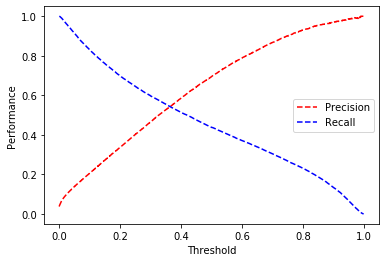

In [71]:
## Threshold PR curve
train_loss, y_true, y_prob = trainer.eval_step(dataloader=train_dataloader)
precisions, recalls, thresholds = precision_recall_curve(y_true.ravel(),y_prob.ravel())
plt.plot(thresholds, precisions[:-1], "r--", label = "Precision")
plt.plot(thresholds, recalls[:-1], "b--", label = "Recall")
plt.ylabel("Performance")
plt.xlabel("Threshold")
plt.legend(loc = "best")

In [72]:
## Determining the best threshold
def find_best_threshold(y_true, y_prob):
    precisions, recalls, thresholds = precision_recall_curve(y_true,y_prob)
    f1s = (2 * precisions * recalls)/(precisions + recalls)
    return thresholds[np.argmax(f1s)]

In [73]:
## Best threshold for f1
threshold = find_best_threshold(y_true.ravel(), y_prob.ravel())
threshold

0.42604163

In [74]:
## Determine predictions using threshold
test_loss, y_true, y_prob = trainer.eval_step(dataloader=test_dataloader)
y_pred = np.array([np.where(prob >= threshold, 1, 0) for prob in y_prob])

In [77]:
## Evaluate
class_names = list(data.columns[2:-1])
performance = get_metrics(y_true=y_true, y_pred=y_pred, classes = class_names)
print(json.dumps(performance['Overall'], indent = 2))

{
  "Precision": 0.6205746762424161,
  "Recall": 0.5000947149081265,
  "F-Score": 0.550899362136056,
  "Num_Samples": 23936.0
}
